In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

# Load data

In [1]:
print('hola git')

hola git


In [2]:
week1_anoms = xr.open_dataset('/glade/work/jhayron/Weather_Regimes/weekly_anomalies/week1_z500_anoms.nc')

week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

# week1_anoms = week1_anoms.sel(time=df_wr_2.index)
week1_anoms = week1_anoms.sel(time=df_wr.index)
week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)

## Quick check anomalies

In [9]:
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1_v2  = xr.open_dataset(f'{path_files}era5_z500_anoms_mean_week1.nc')

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


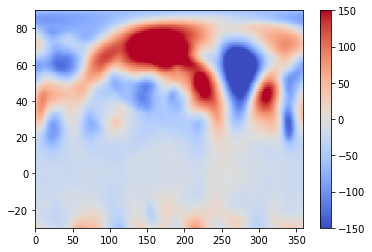

In [10]:
plt.pcolormesh(anoms_week_1_v2.lon,anoms_week_1_v2.lat,
               anoms_week_1_v2.isel(time= 0).anom,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


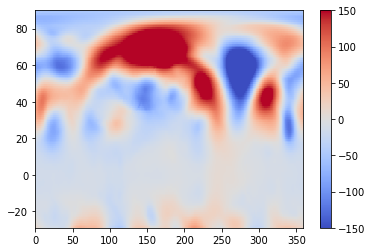

In [11]:
plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,
               week1_anoms.sel(time = datetime(1999,1,4)).z500_anomalies/9.82,
              vmin=-150,vmax=150,cmap='coolwarm')
plt.colorbar()

## Quick check WR

In [12]:
serie_wr_week = np.load(f'{path_files}Serie_WR_Week{1}.npy')

In [13]:
df_old = pd.DataFrame(serie_wr_week,index = pd.to_datetime(anoms_week_1_v2.date_range.values))

In [14]:
df_old2 = copy.deepcopy(df_old)

In [15]:
df_old2[df_old==0] = 1
df_old2[df_old==1] = 0
df_old2[df_old==2] = 3
df_old2[df_old==3] = 2


In [16]:
df_comparison = pd.concat([df_old2,df_wr.week1],axis=1).dropna()

# Build model

In [32]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

## Tests

In [21]:
week_output_wr = df_wr.week2.values.astype(int)
# week_output_wr = df_wr_2.week2.values.astype(int)

# Make Y categorical
serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

# # Scale by standard deviation
# standard_deviation = week1_anoms.z500_anomalies.std(dim='time')
# scaled_x = week1_anoms.z500_anomalies / standard_deviation

Min = week1_anoms.z500_anomalies.min(dim='time')
Max = week1_anoms.z500_anomalies.max(dim='time')

scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

indices = np.arange(len(serie_wr_categorical))
#Reshape X
scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

X_train, X_test, y_train, y_test, indices_train, indices_test \
    = train_test_split(scaled_x, serie_wr_categorical, indices, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val, indices_train, indices_val \
    = train_test_split(X_train, y_train, indices_train, test_size=0.17647058823529413, random_state=42) 
# 0.17647058823529413 x 0.85 = 0.15


In [28]:
wr_persistence = df_wr.week1.values.astype(int)[indices_test]
serie_wr_persistence_categorical = to_categorical(wr_persistence)

In [14]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model

keras.backend.clear_session()

# from tensorflow import set_random_seed
# set_random_seed(2)
model = create_model()

# visualkeras.layered_view(model).show() # display using your system viewer
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
# visualkeras.layered_view(model, scale_xy=1, legend=True,to_file=f'{path_figures}CNN_v1.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

batch_size = 128
epochs = 200
earlystop = EarlyStopping(monitor='val_loss', patience=5)
filepath = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights/checkpoint_w2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                             mode='auto',save_weights_only=False)
model.fit(X_train, y_train, batch_size=batch_size,\
    epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])


Epoch 1/200
15/15 [==============================] - 5s 316ms/step - loss: 1.3719 - accuracy: 0.3313 - val_loss: 1.3565 - val_accuracy: 0.3531
Epoch 2/200
15/15 [==============================] - 5s 302ms/step - loss: 1.3503 - accuracy: 0.3341 - val_loss: 1.3391 - val_accuracy: 0.3531
Epoch 3/200
15/15 [==============================] - 5s 302ms/step - loss: 1.3310 - accuracy: 0.3479 - val_loss: 1.3260 - val_accuracy: 0.4124
Epoch 4/200
15/15 [==============================] - 5s 303ms/step - loss: 1.3109 - accuracy: 0.3667 - val_loss: 1.3081 - val_accuracy: 0.3918
Epoch 5/200
15/15 [==============================] - 5s 306ms/step - loss: 1.2905 - accuracy: 0.3722 - val_loss: 1.2887 - val_accuracy: 0.4381
Epoch 6/200
15/15 [==============================] - 5s 304ms/step - loss: 1.2646 - accuracy: 0.4292 - val_loss: 1.2699 - val_accuracy: 0.4691
Epoch 7/200
15/15 [==============================] - 5s 300ms/step - loss: 1.2369 - accuracy: 0.4563 - val_loss: 1.2469 - val_accuracy: 0.4768

In [15]:
model.load_weights(filepath)

In [16]:
model.evaluate(x=X_test,y=y_test)

13/13 [==============================] - 0s 19ms/step - loss: 1.1945 - accuracy: 0.4897


[1.1945356130599976, 0.48969072103500366]

In [29]:
log_loss(y_test,serie_wr_persistence_categorical)

19.316789892530934

In [30]:
log_loss(y_test,model.predict(X_test))

1.1945356716853135

In [33]:
accuracy_score(y_test,serie_wr_persistence_categorical)

0.44072164948453607

In [51]:
y_predicted_test = model.predict(X_test)

In [56]:
y_predicted_test_discrete = np.zeros_like(y_predicted_test)
for i in range(len(y_predicted_test_discrete)):
    y_predicted_test_discrete[i,np.argmax(y_predicted_test,axis=1)[i]] = 1

In [50]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 0s 19ms/step - loss: 1.1945 - accuracy: 0.4897


[1.1945356130599976, 0.48969072103500366]

In [57]:
accuracy_score(y_test,y_predicted_test_discrete)

0.4896907216494845

# Train definitive

In [18]:
def create_model(activation_conv = ReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 2

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding='same'))
    model.add(AveragePooling2D((ks, ks),padding='same'))
    
    model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Conv2D(256, (ks, ks), activation=activation_conv,padding='same'))
    model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    # model.add(Conv2D(128, (ks, ks), activation=activation_conv,padding='same'))
    # model.add(AveragePooling2D(pool_size=(ks, ks),padding='same'))
    
    model.add(Flatten())
    model.add(Dense(256, activation=activation_conv))                
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model


In [67]:
loss_weeks_model = []
loss_weeks_persistence = []
acc_weeks_model = []
acc_weeks_persistence = []

for week in ['week2','week3','week4','week5','week6']:
    print(week)
    #### ORGANIZE DATA ####
    
    week_output_wr = df_wr[week].values.astype(int)
    # Make Y categorical
    serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)

    # # Scale by min-max
    Min = week1_anoms.z500_anomalies.min(dim='time')
    Max = week1_anoms.z500_anomalies.max(dim='time')
    scaled_x = (week1_anoms.z500_anomalies) / (Max - Min)

    indices = np.arange(len(serie_wr_categorical))
    
    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)
    
    # Split train, test, and validation
    X_train, X_test, y_train, y_test, indices_train, indices_test \
        = train_test_split(scaled_x, serie_wr_categorical, indices, test_size=0.15, random_state=42)

    X_train, X_val, y_train, y_val, indices_train, indices_val \
        = train_test_split(X_train, y_train, indices_train, test_size=0.15/0.85, random_state=42) 

    wr_persistence = df_wr.week1.values.astype(int)[indices_test]
    serie_wr_persistence_categorical = to_categorical(wr_persistence)
    
    #### TRAIN ####
    
    keras.backend.clear_session()
    model = create_model()
    batch_size = 128
    epochs = 200
    
    earlystop = EarlyStopping(monitor='val_loss', patience=5)
    filepath = f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_{week}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                 mode='auto',save_weights_only=False)
    model.fit(X_train, y_train, batch_size=batch_size,\
        epochs=epochs,verbose=0,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])
    
    #### EVAL ####
    
    model.load_weights(filepath)
    model.save(filepath)
    metrics_model = model.evaluate(x=X_test,y=y_test)
    acc_temp = metrics_model[1]
    loss_temp = metrics_model[0]
    acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
    loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
    print('loss/acc model')
    print(metrics_model)
    print('loss/acc persistence')
    print([loss_persistence,acc_persistence])
    
    loss_weeks_model.append(loss_temp)
    loss_weeks_persistence.append(loss_persistence)
    acc_weeks_model.append(acc_temp)
    acc_weeks_persistence.append(acc_persistence)


week2
13/13 [==============================] - 0s 19ms/step - loss: 1.2083 - accuracy: 0.4845
loss/acc model
[1.2082507610321045, 0.4845360815525055]
loss/acc persistence
[19.316789892530934, 0.44072164948453607]
week3
13/13 [==============================] - 0s 19ms/step - loss: 1.2711 - accuracy: 0.4149
loss/acc model
[1.2710729837417603, 0.4149484634399414]
loss/acc persistence
[23.856680604600413, 0.30927835051546393]
week4
13/13 [==============================] - 0s 20ms/step - loss: 1.3036 - accuracy: 0.4381
loss/acc model
[1.3036134243011475, 0.438144326210022]
loss/acc persistence
[25.81506483333627, 0.25257731958762886]
week5
13/13 [==============================] - 0s 19ms/step - loss: 1.3404 - accuracy: 0.3737
loss/acc model
[1.3403754234313965, 0.37371134757995605]
loss/acc persistence
[25.637029903451193, 0.25773195876288657]
week6
13/13 [==============================] - 0s 20ms/step - loss: 1.3455 - accuracy: 0.3557
loss/acc model
[1.3455063104629517, 0.35567009449005127

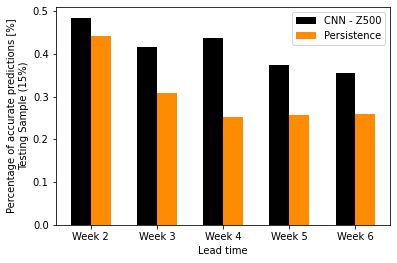

In [68]:
plt.bar(np.arange(5),acc_weeks_model,width=-0.3,align='edge',label='CNN - Z500',color='k')
plt.bar(np.arange(5),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (15%)')
plt.xticks(np.arange(5),['Week 2','Week 3','Week 4','Week 5','Week 6'])
plt.xlabel('Lead time')
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Skill_CNNv0vsPersistence.png',bbox_inches='tight')


In [71]:
keras.models.load_model(f'/glade/work/jhayron/Weather_Regimes/models/CNN/weights/model_week2.h5',
                       custom_objects={'ReLU': ReLU})